In [14]:
import numpy as np 
import awkward as ak
import sys
sys.path.append("..")
from binary_decoders import lecroy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

/tmp/ipykernel_2246588/3848671050.py:14: RuntimeWarning: invalid value encountered in power
  result[mask] = A * (A / (A - 1))**(-t[mask] / t0) - A


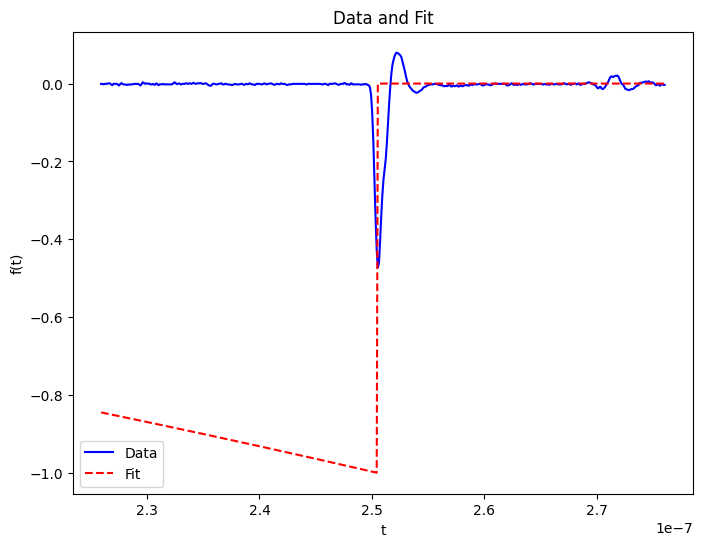

In [ ]:
mcp_data = lecroy.LecroyReader("/home/users/hswanson13/ETL_TestingDAQ/unit_test/input_data/run_5100/C2--Trace5100.trc")

#plt.scatter(mcp_data.x[5], mcp_data.y[5], s=1)

# Extract the x and y data
t_data = mcp_data.x[5]
y_data = mcp_data.y[5]

# https://psec.uchicago.edu/blogs/lappd/wp-content/uploads/2008/08/Analytic_function.pdf

def piecewise_function(t, A, t0):
    result = np.zeros_like(t)
    mask = t < t0
    result[mask] = A * (A / (A - 1))**(-t[mask] / t0) - A
    return result

def fit_signal(t_data, signal_data):
    # Initial guesses for A and t0
    initial_guesses = [np.min(signal_data), t_data[np.argmin(signal_data)]]

    # Curve fitting
    params, covariance = curve_fit(piecewise_function, t_data, signal_data, p0=initial_guesses)
    
    return params

